In [ ]:
# vanilla_rnn_pytorch.py

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# -----------------------------
# 1. Data Loading & Preprocessing
# -----------------------------
def load_text_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    chars = sorted(list(set(text)))
    char_to_idx = {ch: i for i, ch in enumerate(chars)}
    idx_to_char = {i: ch for ch, i in char_to_idx.items()}
    data = torch.tensor([char_to_idx[ch] for ch in text], dtype=torch.long)
    print(f"Text document contains {len(text)} characters and has {len(chars)} unique characters")
    return data, char_to_idx, idx_to_char

In [3]:
# -----------------------------
# 2. Model Definition
# -----------------------------
class VanillaRNNModel(nn.Module):
    def __init__(self, vocab_size, hidden_dim):
        super(VanillaRNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.embed = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x, hidden):
        x = self.embed(x)
        out, hidden = self.rnn(x, hidden) # out => hidden states, # hidden => final hidden state
        logits = self.fc(out) # logits => y_t = Why.T h_t
        return logits, hidden
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_dim)

In [4]:
# -----------------------------
# 3. Training Setup
# -----------------------------
def train(model, data, seq_length, num_iters=20000, lr=0.1, epoch_size=100):
    optimizer = optim.Adagrad(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss() # Loss function
    
    pointer, curr_iter = 0, 0
    steps, losses = [], []
    hidden = model.init_hidden()

    while curr_iter < num_iters:
        if pointer + seq_length + 1 >= len(data):
            hidden = model.init_hidden()
            pointer = 0

        inputs = data[pointer:pointer+seq_length].unsqueeze(0)  # shape (1, seq_len)
        targets = data[pointer+1:pointer+seq_length+1].unsqueeze(0)

        optimizer.zero_grad()
        logits, hidden = model(inputs, hidden.detach())  # detach hidden to truncate BPTT
        loss = criterion(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))
        loss.backward()
        optimizer.step()

        if curr_iter % epoch_size == 0:
            steps.append(curr_iter)
            losses.append(loss.item())
            print(f"Step {curr_iter}/{num_iters} - Loss: {loss.item():.4f}")

        curr_iter += 1
        pointer += seq_length

    return steps, losses, hidden

In [5]:
# -----------------------------
# 4. Text Sampling
# -----------------------------
def sample(model, start_char, char_to_idx, idx_to_char, hidden, sample_length=200):
    model.eval()
    input_idx = torch.tensor([[char_to_idx[start_char]]])
    generated = [start_char]

    for _ in range(sample_length):
        logits, hidden = model(input_idx, hidden)
        probs = torch.softmax(logits[:, -1, :], dim=-1)
        next_idx = torch.multinomial(probs, num_samples=1).item()
        next_char = idx_to_char[next_idx]
        generated.append(next_char)
        input_idx = torch.tensor([[next_idx]])

    return ''.join(generated)

Text document contains 5378667 characters and has 107 unique characters
Step 0/20000 - Loss: 4.7671
Step 100/20000 - Loss: 2.9860
Step 200/20000 - Loss: 1.3949
Step 300/20000 - Loss: 2.2809
Step 400/20000 - Loss: 1.8359
Step 500/20000 - Loss: 2.0094
Step 600/20000 - Loss: 1.8463
Step 700/20000 - Loss: 2.1835
Step 800/20000 - Loss: 2.0370
Step 900/20000 - Loss: 2.1361
Step 1000/20000 - Loss: 1.6361
Step 1100/20000 - Loss: 1.9442
Step 1200/20000 - Loss: 1.5480
Step 1300/20000 - Loss: 1.5258
Step 1400/20000 - Loss: 1.8482
Step 1500/20000 - Loss: 1.7507
Step 1600/20000 - Loss: 2.1637
Step 1700/20000 - Loss: 1.6569
Step 1800/20000 - Loss: 1.9059
Step 1900/20000 - Loss: 2.1838
Step 2000/20000 - Loss: 2.1288
Step 2100/20000 - Loss: 1.8638
Step 2200/20000 - Loss: 1.9228
Step 2300/20000 - Loss: 2.0171
Step 2400/20000 - Loss: 1.7788
Step 2500/20000 - Loss: 1.7029
Step 2600/20000 - Loss: 1.9891
Step 2700/20000 - Loss: 2.0627
Step 2800/20000 - Loss: 1.8707
Step 2900/20000 - Loss: 1.8952
Step 3000/

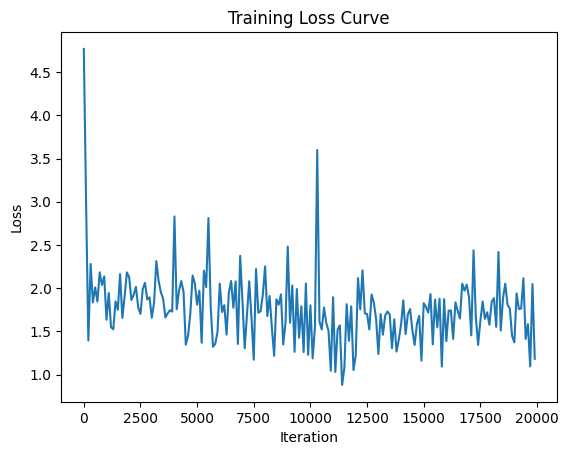

-------------
TZ. That Gords._]

GUILENALDO.
Than sor, he tound;
     What most not excool’d, padvre’s fach yourch fine’s sound that though the looks fortiecnt torous.

POLONIUS.
My and ill us stors fings
 Exice hery,
I’ the med toin bet they of give, him libe sountnow,
    Evow to falls bath. I’l. Iance
And sine,
Lets such, a goods o’emen of awnee bed, faugh Iff had, in theest’ the mad, him op of his reck and are put a atther, if the gure as hath his ariostreavs as me, what’s should the res, we boul a falsece
-------------


In [6]:
# -----------------------------
# 5. Run Everything

# -----------------------------
if __name__ == "__main__":
    torch.manual_seed(42)

    text_data, char_to_idx, idx_to_char = load_text_data("rnn/datasets/shakespeare.txt")

    hidden_dim = 100
    seq_length = 50
    learning_rate = 1e-1
    total_iters = 20000

    model = VanillaRNNModel(len(char_to_idx), hidden_dim)
    steps, losses, hidden = train(model, text_data, seq_length, total_iters, learning_rate)

    plt.plot(steps, losses)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.show()

    start_char = 'T'
    hidden = model.init_hidden()
    generated_text = sample(model, start_char, char_to_idx, idx_to_char, hidden, 500)
    print("-------------\n" + generated_text + "\n-------------")